# Gravitational Wave to Spike Conversion: Physics & Mathematics
    
## Introduction
This notebook explores the process of converting continuous Gravitational Wave (GW) strain data into discrete spikes for Spiking Neural Networks (SNNs). We use **Delta Modulation**, a technique inspired by how biological neurons encode changes in stimuli.

### Why Spikes?
1.  **Energy Efficiency**: SNNs only compute when a spike occurs (event-driven).
2.  **Temporal Resolution**: Spikes can capture precise timing of events, crucial for the "chirp" phase of a binary black hole merger.
3.  **Dynamic Range**: Delta modulation focuses on *changes*, effectively filtering out slow-moving noise while highlighting transient signals like GWs.


In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch
import h5py

# Add src to path
sys.path.append('..')

from src.data_handling.torch_dataset import HDF5SFTPairDataset
from src.models.encoders import DeltaModulationEncoder

# Configuration
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Loading and Reconstructing the Signal
We load a sample from our generated HDF5 dataset. The data is stored as STFT (spectrograms) to save space and allow frequency masking. We use the Inverse STFT (ISTFT) to reconstruct the time-domain strain.

Analyzing Sample ID: 000001


/Users/gracjanziemianski/Documents/CPC-SNN-GravitationalWavesDetection/notebooks/../src/data_handling/torch_dataset.py:108: UserWarning: NOLA condition failed, STFT may not be invertible. Possibly due to missing boundary
  _, x_rec = istft(


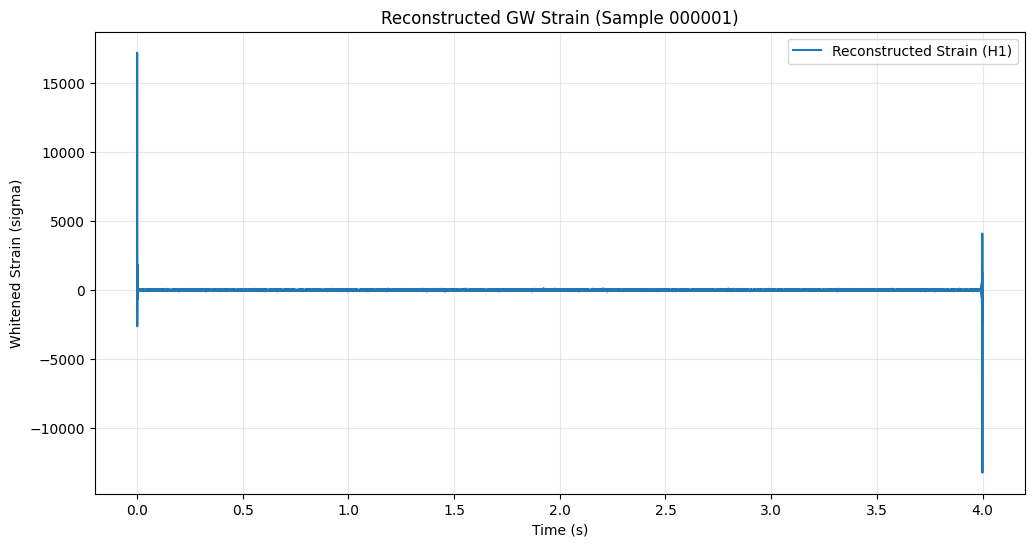

In [2]:
# Load Dataset
h5_path = "../data/cpc_snn_train.h5"

# Get a list of keys
with h5py.File(h5_path, 'r') as f:
    keys = [k for k in f.keys() if k.isdigit()]
    # Find a signal sample
    signal_keys = []
    for k in keys:
        if f[f"{k}/meta"].attrs['is_signal'] == 1:
            signal_keys.append(k)
            if len(signal_keys) > 5: break

target_id = signal_keys[0]
print(f"Analyzing Sample ID: {target_id}")

# Initialize Dataset with return_time_series=True
dataset = HDF5SFTPairDataset(h5_path, [target_id], return_time_series=True)
sample = dataset[0]

# Extract H1 strain
strain = sample['x'][0].numpy() # Channel 0 = H1
time_axis = np.linspace(0, len(strain)/4096.0, len(strain))

plt.figure()
plt.plot(time_axis, strain, label='Reconstructed Strain (H1)')
plt.title(f"Reconstructed GW Strain (Sample {target_id})")
plt.xlabel("Time (s)")
plt.ylabel("Whitened Strain (sigma)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 2. Delta Modulation: The Mathematics
    
The Delta Modulation Encoder tracks a reconstruction signal $\hat{x}(t)$.
At each time step $t$:
1. Calculate error: $e_t = x(t) - \hat{x}(t-1)$
2. Compare to threshold $\delta$:
   - If $e_t > \delta$: Generate **Positive Spike** (+1), update $\hat{x}(t) = \hat{x}(t-1) + \delta$
   - If $e_t < -\delta$: Generate **Negative Spike** (-1), update $\hat{x}(t) = \hat{x}(t-1) - \delta$
   - Else: No Spike (0), $\hat{x}(t) = \hat{x}(t-1)$

This acts as a discrete derivative encoder. For a GW chirp, which changes frequency and amplitude rapidly, this produces a dense burst of spikes.

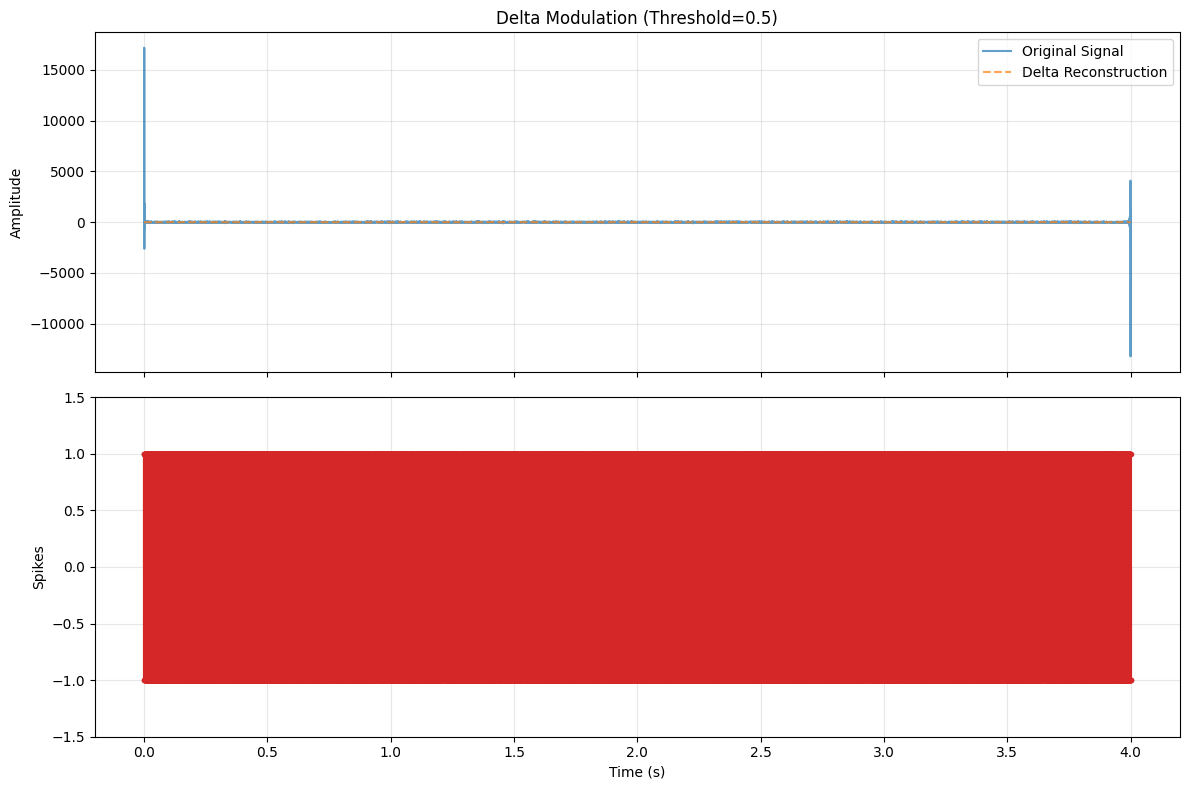

In [3]:
# Initialize Encoder
# Data is normalized to unit variance (sigma=1).
# Threshold of 0.5 corresponds to 0.5 sigma change.
threshold = 0.5
encoder = DeltaModulationEncoder(threshold=threshold)

# Prepare input tensor (Batch, Channels, Time)
x_tensor = torch.from_numpy(strain).unsqueeze(0).unsqueeze(0)

# Run Encoder
spikes = encoder(x_tensor)
spikes_np = spikes.squeeze().numpy()

# We also want to visualize the internal reconstruction for the demo
# Let's manually run the loop to capture 'recon'
recon = np.zeros_like(strain)
curr_recon = 0
for t in range(len(strain)):
    err = strain[t] - curr_recon
    if err > threshold:
        curr_recon += threshold
    elif err < -threshold:
        curr_recon -= threshold
    recon[t] = curr_recon

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Plot 1: Signal vs Reconstruction
ax1.plot(time_axis, strain, label='Original Signal', alpha=0.7)
ax1.plot(time_axis, recon, label='Delta Reconstruction', linestyle='--', alpha=0.7)
ax1.set_ylabel("Amplitude")
ax1.legend(loc='upper right')
ax1.set_title(f"Delta Modulation (Threshold={threshold})")
ax1.grid(True, alpha=0.3)

# Plot 2: Spikes
# Create stem plot for spikes
spike_times = time_axis[spikes_np != 0]
spike_vals = spikes_np[spikes_np != 0]

ax2.stem(spike_times, spike_vals, basefmt=" ", markerfmt="C3.", linefmt="C3-")
ax2.set_ylabel("Spikes")
ax2.set_xlabel("Time (s)")
ax2.set_ylim(-1.5, 1.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Animation: Watching the Spikes Form
    
Below is an animation showing the signal evolving over time and the corresponding spikes being generated. This visualizes how the SNN "sees" the gravitational wave.

In [4]:
# Animation
# Let's zoom in on the merger part for the animation
# Find peak amplitude
peak_idx = np.argmax(np.abs(strain))
start_idx = max(0, peak_idx - 200)
end_idx = min(len(strain), peak_idx + 200)

zoom_strain = strain[start_idx:end_idx]
zoom_recon = recon[start_idx:end_idx]
zoom_spikes = spikes_np[start_idx:end_idx]
zoom_time = time_axis[start_idx:end_idx]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

line_sig, = ax1.plot([], [], 'b-', label='Signal', alpha=0.6)
line_rec, = ax1.plot([], [], 'g--', label='Reconstruction', alpha=0.8)
scat_spikes = ax2.scatter([], [], c='r', s=10)

ax1.set_xlim(zoom_time[0], zoom_time[-1])
ax1.set_ylim(min(zoom_strain)*1.2, max(zoom_strain)*1.2)
ax1.legend()
ax1.set_ylabel("Amplitude")
ax1.set_title("Live Spike Encoding")

ax2.set_xlim(zoom_time[0], zoom_time[-1])
ax2.set_ylim(-1.5, 1.5)
ax2.set_ylabel("Spike")
ax2.set_xlabel("Time (s)")

def init():
    line_sig.set_data([], [])
    line_rec.set_data([], [])
    scat_spikes.set_offsets(np.empty((0, 2)))
    return line_sig, line_rec, scat_spikes

def update(frame):
    # Frame goes from 0 to len(zoom_strain)
    current_time = zoom_time[:frame]
    current_sig = zoom_strain[:frame]
    current_rec = zoom_recon[:frame]
    
    line_sig.set_data(current_time, current_sig)
    line_rec.set_data(current_time, current_rec)
    
    # Spikes
    current_spikes = zoom_spikes[:frame]
    spike_indices = np.where(current_spikes != 0)[0]
    if len(spike_indices) > 0:
        points = np.column_stack((current_time[spike_indices], current_spikes[spike_indices]))
        scat_spikes.set_offsets(points)
    
    return line_sig, line_rec, scat_spikes

ani = animation.FuncAnimation(fig, update, frames=len(zoom_strain), init_func=init, blit=True, interval=20)
plt.close() # Don't show the static plot
HTML(ani.to_jshtml())


## 4. Physics & Astronomy Context
    
### The "Chirp"
Gravitational waves from binary mergers (BBH, BNS) are characterized by a "chirp" signal: frequency and amplitude increase over time as the objects spiral closer.

### Why Delta Modulation fits Physics
- **Sparsity**: Most of the time, the detector noise is relatively stationary (Gaussian-like). Delta modulation with an appropriate threshold will produce few spikes for this background noise.
- **Transient Sensitivity**: When a GW chirp arrives, the rapid change in amplitude forces the delta modulator to spike frequently to "catch up" with the signal.
- **Information Density**: The spike rate correlates directly with the signal's rate of change (derivative), encoding the crucial frequency and amplitude evolution of the chirp in a compact, binary format.

This makes SNNs a potentially powerful tool for **low-latency** detection pipelines, as they can react to the onset of a chirp (burst of spikes) faster than traditional matched filtering which requires integrating over the entire template duration.
